In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from halo import sim_halo
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import constants as const
from scipy import stats
import h5py
import os
import utilities as ut

# Scattering

In [4]:
sim_name = 'm12f_res7100'
halo = sim_halo(sim_name)


# in utilities.simulation.Snapshot():
* reading:  pool001/zimi/analysis/FIRE/m12f_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in halo_analysis.halo_io.IO():
* read 59085 halos from:  pool001/zimi/analysis/FIRE/m12f_res7100/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5

# in halo_analysis.halo_io.Particle():
! cannot find halo file:  pool001/zimi/analysis/FIRE/m12f_res7100/halo/rockstar_dm/catalog_hdf5/gas_600
* assigning primary host and coordinates wrt it to halo catalog...  finished


# in utilities.simulation.Snapshot():
* reading:  pool001/zimi/analysis/FIRE/m12f_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  pool001/zimi/analysis/FIRE/m12f_res7100/output/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 96239056 particles
    dark2     (id = 2): 7591203 particles
    g

In [5]:
halo.read_gas_files(cooling = True)

In [6]:
max_potential = max(halo.gas_data[0]['potential'] + halo.gas_data[1]['potential'] + halo.gas_data[2]['potential'] + halo.gas_data[3]['potential'])

In [7]:
halo_gas = halo.in_halo(region = 'cgm', save = True)

## Shattering


### Hot phase temperature


In [ ]:
def plot2d(x, y, value, cmap = 'viridis', bins = 150, norm = None, vmin = None, vmax = None):
    mean, xbins, ybins, binnumber = stats.binned_statistic_2d(x, y, value, bins = bins)

    # with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
    plot = plt.pcolormesh(ybins, xbins, mean, cmap = cmap, norm = norm, vmin = vmin, vmax = vmax)

    return plot

In [24]:


for i, chunk in enumerate(halo_gas):
    gamma = 5/3
    y = chunk['helium']
    f_e = chunk['electron_abundance']
    rho = chunk['density']
    # u = chunk['internal_energy']
    temp = chunk['temperature']

    mu = 1/((1-y) + y/4 + (1-y)*f_e)
    mbar = mu*ut.constant.proton_mass
    # temp = (gamma - 1)*u*mbar/const.k_B
    n = rho/mbar

    # t_cross = chunk['bin_size']*3.09e16/c_s                 # crossing time
    t_cool = chunk['cooling_times']                               # cooling time in cgs, positive when heating, negative when cooing
    rate_cool = chunk['cooling_rates']
    t_ff = (2*chunk['dist_tot']/3)*np.sqrt(-1/(chunk['potential'] - max_potential))           # freefall time in cgs, positive

    # select particles that meet shattering criteria
    xi = 10
    shattered_idx = ((-t_cool/t_ff) < xi) & ((-t_cool/t_ff) > 0)
    shattered = chunk[shattered_idx]

    np.save(f"/pool001/zimi/grackle/grackle_data_files/input/shattered_mask_{i}", shattered_idx)

    # percentage of gas shattered
    print(str(len(shattered)/len(chunk)*100) + "%" + " shattered")

    # id = (shattered['temperature'] < 1e4)

    # hot phase and cold phase density
    T_c = 10**4.3   # cold temperature
    n_h = (mu**2*const.k_B*temp)/((gamma-1)*rate_cool*xi*t_ff)
    n_c = (n_h*temp/T_c)[shattered_idx]

    np.save(f"/pool001/zimi/grackle/grackle_data_files/input/n_c_{i}", n_c)

    

4.798738122483042% shattered
3.6025854509651345% shattered
6.48848563227239% shattered
7.114413570281037% shattered


In [13]:
t_cool_cold, rate_cool_cold = halo.get_cooling(phase = 'Cold')

ValueError: need at least one array to concatenate

In [ ]:
c_s = np.sqrt(gamma*(gamma-1)*T_c)      # sound speed

In [ ]:
# calculate cloudlet size

scattering 

### some plotting

In [ ]:
# get slice that is within 1pc of z=0
location_mask = (shattered['dist_z'] <= 0.2)
shattered_loc_masked = shattered[location_mask]

In [21]:
not_shattered = np.logical_not(shattered_idx)

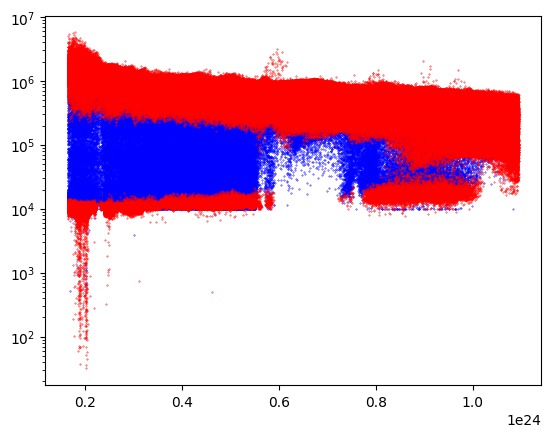

In [22]:
plt.scatter(shattered['dist_tot'], shattered['temperature'], s = 0.1, c = 'b')
plt.scatter(halo_gas[3][not_shattered]['dist_tot'], halo_gas[3][not_shattered]['temperature'], s = 0.1, c = 'r')
plt.yscale('log')
 

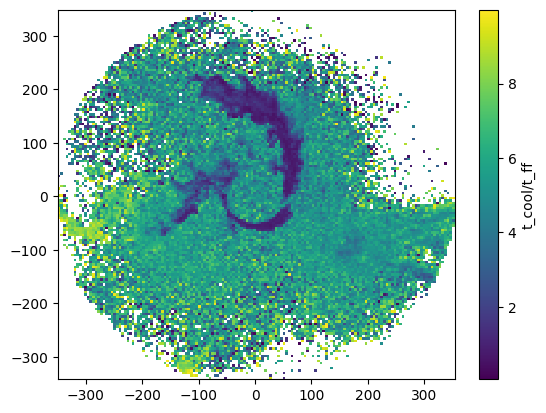

In [ ]:
plot2d(shattered_loc_masked['dist_x'], shattered_loc_masked['dist_y'], value = (-((t_cool)/(t_ff)))[shattered_idx][location_mask], bins = 150)
cbar = plt.colorbar()
cbar.set_label('t_cool/t_ff')

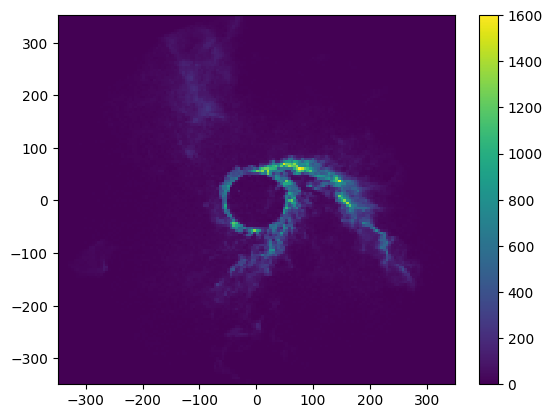

In [ ]:
plt.hist2d(shattered['dist_x'], shattered['dist_y'], bins = 150)
bar = plt.colorbar()
cbar.set_label('t_cool/t_ff')

In [ ]:
# are shattered cells next to each other?
# number density of selected points?